The most common example of a system that exhibits chaos is the double pendulum. In the double pendulum setting we know that small perturbations to the initial conditions significantly influence the trajectory. How best can we capture such changes?

The lagrangian of a system is:

$$ L = T(q,\dot{q}) - V(q) $$ and $$ \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = \tau$$

gives us the Euler-Lagrange equation with generalized forces

If $ T = \dot{q}^T M(q) \dot{q} $ and V is only a function of q, then:

$$ \frac{\partial L}{\partial \dot{q}} = p = M(q)\dot{q}$$

$$ \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} = \frac{dp}{dt} = \dot{M(q)}\dot{q} + M(q)\ddot{q} $$

Then,if we have no generalized forces:

$$\dot{M(q)}\dot{q} + M(q)\ddot{q} - \frac{\partial L}{\partial q} = 0 $$

$$ \ddot{q} = M(q)^{-1} (\frac{\partial L}{\partial q} - \dot{M(q)} \dot{q}) $$

Deep Lagrangian Nets https://arxiv.org/pdf/1907.04490.pdf - solves the above equation by learning each component and breaking the lagrangian L into a lower triangular times its transpose.

One unique aspect about VIGN is that we don't need to explicitly model the time derivative of M which is a bottle neck of the approach given above. so:

Given $[q_t,\dot{q_t}]$ $\rightarrow$ L $\rightarrow [p_t,\dot{p_t}] $ so now the state is basically:

given our initial state, we want to be able to update $[q_t,\dot{q_t}]$, the way to do this is:

$$ dq_t/dt = \dot{q_t}$$
$$ dp_t/dt = dL/dq $$

$$[q_{t+1},p_{t+1}] $$, but, if we learn M(q) then $$[q_{t+1},M^{-1}(q_{t+1})p_{t+1})]$$

***

In [1]:
from data_builder import *
from utils import *
from model import *
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
expt_name = 'test'
num_trajectories = 1
n_test_traj = 1
num_nodes = 2
T_max = 10.01
dt = 0.01
srate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


train_data = doublepend( expt_name, num_trajectories, num_nodes, T_max, dt, srate, 0,yflag=False)
valid_data = doublepend( expt_name, n_test_traj, num_nodes, 2*T_max,dt,srate, 0,yflag=False)



cpu


In [3]:
x1,y1,x2,y2 = theta_to_cart(train_data['x'])
x1_t,y1_t,x2_t,y2_t = theta_to_cart(valid_data['x'])

<AxesSubplot:>

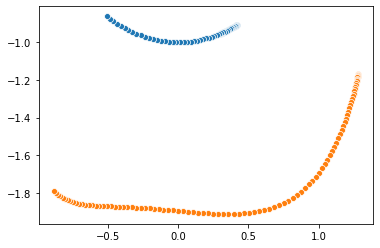

In [4]:
sns.scatterplot(x=x1,y=y1)
sns.scatterplot(x=x2,y=y2)

In [5]:
train_data['dx']

array([[ 0.00000000e+00,  0.00000000e+00, -6.40780970e-01,
        -9.25487895e+00],
       [-6.38710267e-03, -9.25552170e-02, -6.34568963e-01,
        -9.25680756e+00],
       [-1.26499755e-02, -1.85149041e-01, -6.15936049e-01,
        -9.26260395e+00],
       [-1.86644514e-02, -2.77820292e-01, -5.84891674e-01,
        -9.27229991e+00],
       [-2.43064905e-02, -3.70608213e-01, -5.41452001e-01,
        -9.28594867e+00],
       [-2.94522512e-02, -4.63552689e-01, -4.85640557e-01,
        -9.30362520e+00],
       [-3.39781675e-02, -5.56694464e-01, -4.17489184e-01,
        -9.32542656e+00],
       [-3.77610388e-02, -6.50075366e-01, -3.37039343e-01,
        -9.35147233e+00],
       [-4.06781340e-02, -7.43738530e-01, -2.44343834e-01,
        -9.38190473e+00],
       [-4.26073160e-02, -8.37728630e-01, -1.39469024e-01,
        -9.41688858e+00],
       [-4.34271906e-02, -9.32092094e-01, -2.24977205e-02,
        -9.45661078e+00],
       [-4.30172891e-02, -1.02687733e+00,  1.06467155e-01,
      

In [6]:
def omega(state):
    pt1 = state[:,2] + state[:,3]*np.cos(state[:,0]-state[:,1])
    pt2 = state[:,3] + state[:,2]*np.cos(state[:,0]-state[:,1])
    return np.concatenate([state[:,:2],pt1.reshape(-1,1),pt2.reshape(-1,1)],1)

In [7]:
theta_ps = omega(train_data['x'])

In [8]:
import math

In [11]:
theta_ps_dot = [hamilton_rhs(*theta_ps_i) for theta_ps_i in theta_ps]

In [10]:
 def hamilton_rhs( t1, t2, p1, p2):
        """
        Computes the right-hand side of the Hamilton's equations for
        the double pendulum and returns it as an array.
        t1 - The angle of bob #1.
        t2 - The angle of bob #2.
        p1 - The canonical momentum of bob #1.
        p2 - The canonical momentum of bob #2.
        """

        m1 = 1
        L1 = 1
        m2 = 1
        L2 = 1

        g = 9.81

        C0 = L1 * L2 * (m1 + m2 * math.sin(t1 - t2)**2)
        C1 = (p1 * p2 * math.sin(t1 - t2)) / C0
        C2 = (m2 * (L2 * p1)**2 + (m1 + m2) * (L1 * p2)**2 -
              2 * L1 * L2 * m2 * p1 * p2 * math.cos(t1 - t2)) * \
            math.sin(2 * (t1 - t2)) / (2 * C0**2)

        # F is the right-hand side of the Hamilton's equations
        F_t1 = (L2 * p1 - L1 * p2 * math.cos(t1 - t2)) / (L1 * C0)
        F_t2 = (L1 * (m1 + m2) * p2 - L2 *
                m2 * p1 * math.cos(t1 - t2)) / (L2 * m2 * C0)
        F_p1 = -(m1 + m2) * g * L1 * math.sin(t1) - C1 + C2
        F_p2 = -m2 * g * L2 * math.sin(t2) + C1 - C2

        return np.array([F_t1, F_t2, F_p1, F_p2])

In [7]:
# tnow,tnext = nownext(train_data,num_trajectories,num_nodes,T_max,dt,srate,spatial_dim=2)
# tnow = omega(tnow[0])
# tnext = omega(tnext[0])

In [12]:
traindat = pendpixdata(theta_ps, theta_ps_dot)
train_dataloader = DataLoader(traindat, batch_size=200, num_workers=2, shuffle=True)
# # valdat = pendpixdata(test_xnow, test_xnext)
# val_dataloader = DataLoader(valdat, batch_size=bs_test, num_workers=nw, shuffle=False)
data_dict = {'train': train_dataloader}
running_losses = 0.
loss_collater = []
torch.pi = torch.tensor(np.pi)
def rebase(q):
#     return q
    qs= torch.fmod((q[:,:2] + torch.pi) , (2 * torch.pi)) - torch.pi
    qdots = q[:,2:]
    return torch.cat([qs,qdots],1)
def train_model(model, optimizer, num_epochs=1):

    for epoch in range(num_epochs):
        print('epoch:{}'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # Iterate over data.
            for batch_i, (q, q_next) in enumerate(data_dict[phase]):
                if phase == 'train':
                    optimizer.zero_grad()
                q, q_next = q.float(), q_next.float()
                q.to(device)
                q_next.to(device)
                q.requires_grad = True
                loss = 0
                energy_ = torch.ones(size=q.shape)*train_data['energy'][0]
                if phase == 'train':
                    t1 =time.time()
                    next_step_pred = model.next_step(q)
                    state_loss = ((next_step_pred - q_next) ** 2).mean()
                    energy_loss = 0#((model.forward(rebase(q))-energy_)**2).mean()
                    loss +=  state_loss + energy_loss
                    (loss).backward()
                    print(f'energy:{energy_loss},state:{state_loss}')
                    optimizer.step()
                    loss_collater.append((state_loss,energy_loss))
                running_loss += loss.item()
                    
            epoch_loss = running_loss
            print('{} Loss: {:.10f}'.format(phase, epoch_loss))

            
    return model


model_ft = MODEL(4, 200, 1)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-3)
model_ft = train_model(model_ft, optimizer_ft, num_epochs=1000)


epoch:0
energy:0,state:21.634796142578125
train Loss: 21.6347961426
epoch:1
energy:0,state:21.337677001953125
train Loss: 21.3376770020
epoch:2
energy:0,state:21.04865074157715
train Loss: 21.0486507416
epoch:3
energy:0,state:20.764720916748047
train Loss: 20.7647209167
epoch:4
energy:0,state:20.483278274536133
train Loss: 20.4832782745
epoch:5
energy:0,state:20.202096939086914
train Loss: 20.2020969391
epoch:6
energy:0,state:19.919309616088867
train Loss: 19.9193096161
epoch:7
energy:0,state:19.633441925048828
train Loss: 19.6334419250
epoch:8
energy:0,state:19.343461990356445
train Loss: 19.3434619904
epoch:9
energy:0,state:19.04876708984375
train Loss: 19.0487670898
epoch:10
energy:0,state:18.749126434326172
train Loss: 18.7491264343
epoch:11
energy:0,state:18.444625854492188
train Loss: 18.4446258545
epoch:12
energy:0,state:18.13565444946289
train Loss: 18.1356544495
epoch:13
energy:0,state:17.82286834716797
train Loss: 17.8228683472
epoch:14
energy:0,state:17.507173538208008
train

energy:0,state:1.2480822801589966
train Loss: 1.2480822802
epoch:122
energy:0,state:1.2148784399032593
train Loss: 1.2148784399
epoch:123
energy:0,state:1.1827725172042847
train Loss: 1.1827725172
epoch:124
energy:0,state:1.1516355276107788
train Loss: 1.1516355276
epoch:125
energy:0,state:1.1213356256484985
train Loss: 1.1213356256
epoch:126
energy:0,state:1.0917445421218872
train Loss: 1.0917445421
epoch:127
energy:0,state:1.062750220298767
train Loss: 1.0627502203
epoch:128
energy:0,state:1.0342607498168945
train Loss: 1.0342607498
epoch:129
energy:0,state:1.0062105655670166
train Loss: 1.0062105656
epoch:130
energy:0,state:0.9785599708557129
train Loss: 0.9785599709
epoch:131
energy:0,state:0.951294481754303
train Loss: 0.9512944818
epoch:132
energy:0,state:0.9244195222854614
train Loss: 0.9244195223
epoch:133
energy:0,state:0.8979585766792297
train Loss: 0.8979585767
epoch:134
energy:0,state:0.8719496130943298
train Loss: 0.8719496131
epoch:135
energy:0,state:0.8464419841766357
tr

energy:0,state:0.02675272710621357
train Loss: 0.0267527271
epoch:240
energy:0,state:0.02589005045592785
train Loss: 0.0258900505
epoch:241
energy:0,state:0.025055022910237312
train Loss: 0.0250550229
epoch:242
energy:0,state:0.02424684911966324
train Loss: 0.0242468491
epoch:243
energy:0,state:0.023464839905500412
train Loss: 0.0234648399
epoch:244
energy:0,state:0.022708222270011902
train Loss: 0.0227082223
epoch:245
energy:0,state:0.021976346150040627
train Loss: 0.0219763462
epoch:246
energy:0,state:0.02126844972372055
train Loss: 0.0212684497
epoch:247
energy:0,state:0.020583897829055786
train Loss: 0.0205838978
epoch:248
energy:0,state:0.019921990111470222
train Loss: 0.0199219901
epoch:249
energy:0,state:0.019282041117548943
train Loss: 0.0192820411
epoch:250
energy:0,state:0.018663398921489716
train Loss: 0.0186633989
epoch:251
energy:0,state:0.018065448850393295
train Loss: 0.0180654489
epoch:252
energy:0,state:0.017487527802586555
train Loss: 0.0174875278
epoch:253
energy:0,s

energy:0,state:0.0021628879476338625
train Loss: 0.0021628879
epoch:356
energy:0,state:0.002146228915080428
train Loss: 0.0021462289
epoch:357
energy:0,state:0.0021299386862665415
train Loss: 0.0021299387
epoch:358
energy:0,state:0.0021140011958777905
train Loss: 0.0021140012
epoch:359
energy:0,state:0.002098411088809371
train Loss: 0.0020984111
epoch:360
energy:0,state:0.0020831406582146883
train Loss: 0.0020831407
epoch:361
energy:0,state:0.0020681945607066154
train Loss: 0.0020681946
epoch:362
energy:0,state:0.0020535464864224195
train Loss: 0.0020535465
epoch:363
energy:0,state:0.0020391875877976418
train Loss: 0.0020391876
epoch:364
energy:0,state:0.002025119960308075
train Loss: 0.0020251200
epoch:365
energy:0,state:0.002011319389566779
train Loss: 0.0020113194
epoch:366
energy:0,state:0.00199779961258173
train Loss: 0.0019977996
epoch:367
energy:0,state:0.0019845152273774147
train Loss: 0.0019845152
epoch:368
energy:0,state:0.0019714911468327045
train Loss: 0.0019714911
epoch:36

train Loss: 0.0012338072
epoch:470
energy:0,state:0.0012292424216866493
train Loss: 0.0012292424
epoch:471
energy:0,state:0.001224700128659606
train Loss: 0.0012247001
epoch:472
energy:0,state:0.0012201872887089849
train Loss: 0.0012201873
epoch:473
energy:0,state:0.0012157096061855555
train Loss: 0.0012157096
epoch:474
energy:0,state:0.001211255439557135
train Loss: 0.0012112554
epoch:475
energy:0,state:0.0012068270007148385
train Loss: 0.0012068270
epoch:476
energy:0,state:0.0012024241732433438
train Loss: 0.0012024242
epoch:477
energy:0,state:0.0011980528943240643
train Loss: 0.0011980529
epoch:478
energy:0,state:0.0011937039671465755
train Loss: 0.0011937040
epoch:479
energy:0,state:0.0011893768096342683
train Loss: 0.0011893768
epoch:480
energy:0,state:0.001185080036520958
train Loss: 0.0011850800
epoch:481
energy:0,state:0.0011808121344074607
train Loss: 0.0011808121
epoch:482
energy:0,state:0.001176568097434938
train Loss: 0.0011765681
epoch:483
energy:0,state:0.0011723523493856

energy:0,state:0.0008445457206107676
train Loss: 0.0008445457
epoch:585
energy:0,state:0.0008420448284596205
train Loss: 0.0008420448
epoch:586
energy:0,state:0.0008395509794354439
train Loss: 0.0008395510
epoch:587
energy:0,state:0.0008370733703486621
train Loss: 0.0008370734
epoch:588
energy:0,state:0.0008346049580723047
train Loss: 0.0008346050
epoch:589
energy:0,state:0.0008321520872414112
train Loss: 0.0008321521
epoch:590
energy:0,state:0.0008297029417008162
train Loss: 0.0008297029
epoch:591
energy:0,state:0.0008272717241197824
train Loss: 0.0008272717
epoch:592
energy:0,state:0.0008248460362665355
train Loss: 0.0008248460
epoch:593
energy:0,state:0.0008224295452237129
train Loss: 0.0008224295
epoch:594
energy:0,state:0.0008200284792110324
train Loss: 0.0008200285
epoch:595
energy:0,state:0.0008176385308615863
train Loss: 0.0008176385
epoch:596
energy:0,state:0.0008152552181854844
train Loss: 0.0008152552
epoch:597
energy:0,state:0.0008128862828016281
train Loss: 0.0008128863
ep

energy:0,state:0.0006148759857751429
train Loss: 0.0006148760
epoch:700
energy:0,state:0.0006132806884124875
train Loss: 0.0006132807
epoch:701
energy:0,state:0.0006116927252151072
train Loss: 0.0006116927
epoch:702
energy:0,state:0.0006101116887293756
train Loss: 0.0006101117
epoch:703
energy:0,state:0.000608531991019845
train Loss: 0.0006085320
epoch:704
energy:0,state:0.0006069621304050088
train Loss: 0.0006069621
epoch:705
energy:0,state:0.0006053972174413502
train Loss: 0.0006053972
epoch:706
energy:0,state:0.0006038310239091516
train Loss: 0.0006038310
epoch:707
energy:0,state:0.0006022806046530604
train Loss: 0.0006022806
epoch:708
energy:0,state:0.000600728380959481
train Loss: 0.0006007284
epoch:709
energy:0,state:0.0005991815705783665
train Loss: 0.0005991816
epoch:710
energy:0,state:0.0005976466345600784
train Loss: 0.0005976466
epoch:711
energy:0,state:0.0005961090209893882
train Loss: 0.0005961090
epoch:712
energy:0,state:0.0005945760058239102
train Loss: 0.0005945760
epoc

energy:0,state:0.0004905693349428475
train Loss: 0.0004905693
epoch:814
energy:0,state:0.0005153564270585775
train Loss: 0.0005153564
epoch:815
energy:0,state:0.0005639461451210082
train Loss: 0.0005639461
epoch:816
energy:0,state:0.0006579016335308552
train Loss: 0.0006579016
epoch:817
energy:0,state:0.0008257122244685888
train Loss: 0.0008257122
epoch:818
energy:0,state:0.0011051441542804241
train Loss: 0.0011051442
epoch:819
energy:0,state:0.0014589064521715045
train Loss: 0.0014589065
epoch:820
energy:0,state:0.0017565196612849832
train Loss: 0.0017565197
epoch:821
energy:0,state:0.0016515175811946392
train Loss: 0.0016515176
epoch:822
energy:0,state:0.0011250698007643223
train Loss: 0.0011250698
epoch:823
energy:0,state:0.0005660154856741428
train Loss: 0.0005660155
epoch:824
energy:0,state:0.0004915844765491784
train Loss: 0.0004915845
epoch:825
energy:0,state:0.0008363492088392377
train Loss: 0.0008363492
epoch:826
energy:0,state:0.0010852570412680507
train Loss: 0.0010852570
ep

energy:0,state:0.00035817516618408263
train Loss: 0.0003581752
epoch:928
energy:0,state:0.0003573907306417823
train Loss: 0.0003573907
epoch:929
energy:0,state:0.00035661846050061285
train Loss: 0.0003566185
epoch:930
energy:0,state:0.0003558565804269165
train Loss: 0.0003558566
epoch:931
energy:0,state:0.0003550926339812577
train Loss: 0.0003550926
epoch:932
energy:0,state:0.00035432763979770243
train Loss: 0.0003543276
epoch:933
energy:0,state:0.0003535593277774751
train Loss: 0.0003535593
epoch:934
energy:0,state:0.00035279119038023055
train Loss: 0.0003527912
epoch:935
energy:0,state:0.00035202683648094535
train Loss: 0.0003520268
epoch:936
energy:0,state:0.0003512694966048002
train Loss: 0.0003512695
epoch:937
energy:0,state:0.00035051838494837284
train Loss: 0.0003505184
epoch:938
energy:0,state:0.00034976692404598
train Loss: 0.0003497669
epoch:939
energy:0,state:0.0003490189556032419
train Loss: 0.0003490190
epoch:940
energy:0,state:0.0003482686588540673
train Loss: 0.000348268

In [13]:
loss_coll = np.array(loss_collater)

Text(0.5, 0, 'iterations')

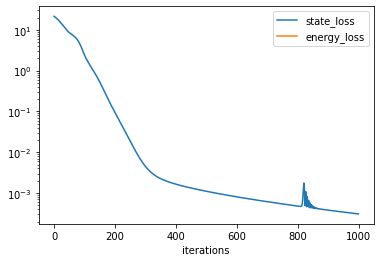

In [14]:
plt.plot(loss_coll[:,0],label='state_loss')
plt.plot(loss_coll[:,1],label='energy_loss')
plt.yscale('log')
plt.legend()
plt.xlabel('iterations')

In [15]:
from scipy.integrate import odeint


In [ ]:
q0

In [ ]:
odeint(model_ft.forward,)

In [ ]:
it = iter(data_dict['train'])
q,q_next = next(it)

In [ ]:
plt.plot(model_ft.forward(q.float()).detach().numpy())

In [ ]:
plt.plot(loss_collater)
plt.yscale('log')

In [ ]:
q=torch.tensor(tnow[0]).float().reshape(-1,4)
q.to(device)
q.requires_grad = True
loss = 0
coll = []
for _ in range(100):
    nstep = model_ft.next_step(q)
    coll.append(nstep.detach().numpy()[0])
    q=nstep
    
                    

In [ ]:
coll = np.array(coll)

In [ ]:
N = 1000
fig,axs = plt.subplots(1,2,figsize=(7,5))
sns.scatterplot(x=range(N),y=coll[:N,3],ax=axs[0])
sns.scatterplot(x=range(N),y=tnext[:N,3],ax=axs[0])
sns.scatterplot(x=range(N),y=coll[:N,1],ax=axs[1])
sns.scatterplot(x=range(N),y=tnext[:N,1],ax=axs[1])
plt.tight_layout()

In [ ]:
# x1_p,y1_p,x2_p,y2_p = theta_to_cart(np.array(coll))

In [ ]:
# x1_p.shape

In [ ]:
# sns.scatterplot(x=x2_p[:50],y=y2_p[:50])
# sns.scatterplot(x=x2[:50],y=y2[:50])

In [ ]:

N = 500
fig,axs = plt.subplots(1,2,figsize=(15,10))
sns.scatterplot(x=range(N),y=y2_p[:N],ax=axs[0])
sns.scatterplot(x=range(N),y=y2[:N],ax=axs[0])
sns.scatterplot(x=range(N),y=x2_p[:N],ax=axs[1])
sns.scatterplot(x=range(N),y=x2[:N],ax=axs[1])
plt.tight_layout()

In [ ]:
x2.shape

In [ ]:
torch.pi

In [ ]:
np.pi

In [ ]:
for batch_i, (q, dq) in enumerate(data_dict['train']):
    print(batch_i)

In [ ]:
model_ft.M_matrix(q[:,:2].float())

In [ ]:
model_ft.Minv

In [ ]:
torch.inverse(model_ft.M[:2,:2])

In [ ]:
import numpy as np

In [ ]:
a = np.random.normal(size=[10,2])

In [ ]:
for (a,b) in zip(a[:,0],a[:,1]):
    print(a)
    print(b)

In [3]:
a = np.random.normal(size=[10,2])

In [7]:
for (a,b) in zip(a[:,0],a[:,1]):
    print(a)
    print(b)

IndexError: invalid index to scalar variable.